# Week 10 (Aaron Kohn)
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.display import display
import random

import thinkstats2
import thinkplot

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])

In [3]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.
    transactions: DataFrame of transactions
    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.
    transaction: DataFrame of transactions
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

dailies = GroupByQualityAndDay(transactions)

In [4]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [5]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color='#ff7f00')
    xlim = years[0]-0.1, years[-1]+0.1
    thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)',
                 loc='upper right')

In [6]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')

## Exercise 12-1 

In [7]:
def RunLinearModel2(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [8]:
name = 'high'
daily = dailies[name]

model, results = RunLinearModel2(daily)
results.summary()    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Thu, 20 May 2021   Prob (F-statistic):          4.57e-164
Time:                        21:48:10   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

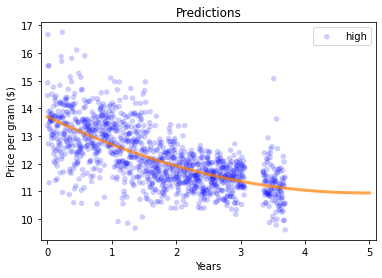

In [9]:
name = 'high'
daily = dailies[name]

_, results = RunLinearModel2(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

<ipython-input-7-9c130940465f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily['years2'] = daily.years**2


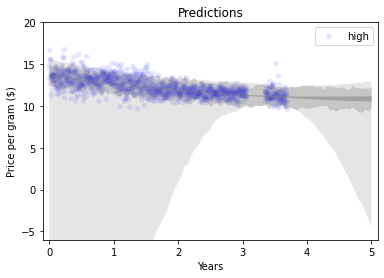

In [10]:
name = 'high'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years, func= RunLinearModel2)
PlotPredictions(daily, years, func= RunLinearModel2)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylim= [-6, 20],
                 ylabel='Price per gram ($)')

## Exercise 12-2

In [11]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(series.autocorr(lag))
        return test_stat
    
    def RunModel(self):
        series, lag = self.data
        rand_model = series.reindex(np.random.permutation(series.index))
        return rand_model, lag

In [12]:
test = SerialCorrelationTest((daily.ppg, 1))
print('The serial corelation is', test.actual,'with a p-value of', test.PValue())

The serial corelation is 0.4852293761947379 with a p-value of 0.0


In [13]:
def RunTest(model= RunLinearModel(daily) ):
    _, results = model
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print('actual =',str(test.actual) + ', p-value =', pvalue)
print('Linear model:')
RunTest()
print('Quadratic model:')
RunTest(model= RunLinearModel2(daily))

Linear model:
actual = 0.07570473767506262, p-value = 0.004
Quadratic model:
actual = 0.05607308161289918, p-value = 0.046
